In [10]:
from cProfile import label

# class that inherits from property based test
import numpy as np
import csv

import pandas
import pandas as pd
from scipy.special import xlogy

pd.options.display.width = 240
# import seaborn as sns
import itertools
import scipy
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylabel, xlabel
from numpy.f2py.cb_rules import cb_map
from qiskit import QuantumCircuit
from sympy.printing.pretty.pretty_symbology import line_width

from qucheck.property import Property
from qucheck.input_generators import RandomState
from qucheck.test_runner import TestRunner

import pandas as pd
import numpy as np
import ast

def return_properties(df):
    property_pvals_noise = {}
    property_pvals_qoin = {}
    property_pvals_id = {}

    for index, row in df.iterrows():
        for entry in row["noise_pvals"]:
            prop = entry["property_name"]
            if prop not in property_pvals_noise:
                property_pvals_noise[prop] = []
            property_pvals_noise[prop].extend(entry["p_values"])

        for entry in row["qoin_pvals"]:
            prop = entry["property_name"]
            if prop not in property_pvals_qoin:
                property_pvals_qoin[prop] = []
            property_pvals_qoin[prop].extend(entry["p_values"])

        for entry in row["id_pvals"]:
            prop = entry["property_name"]
            if prop not in property_pvals_id:
                property_pvals_id[prop] = []
            property_pvals_id[prop].extend(entry["p_values"])
    return property_pvals_noise, property_pvals_qoin, property_pvals_id

def read_to_df_and_clean(algorithm_name):
    def read_closeness_data_to_dataframe(algorithm_name_):
        filename = f"mutation_test_results/{algorithm_name_}/{algorithm_name_}_qoin_closeness_vs_p_val.csv"
        df = pd.read_csv(filename)
        return df

    df = read_closeness_data_to_dataframe(algorithm_name)

    # Convert lists from strings to actual lists
    df["hellinger_noise_distances"] = df["hellinger_noise_distances"].apply(ast.literal_eval)
    df["hellinger_qoin_distances"]  = df["hellinger_qoin_distances"].apply(ast.literal_eval)
    df["noise_pvals"]               = df["noise_pvals"].apply(ast.literal_eval)
    df["qoin_pvals"]                = df["qoin_pvals"].apply(ast.literal_eval)
    df["id_pvals"]                  = df["id_pvals"].apply(ast.literal_eval)
    df["hellinger_id_eq_distances"] = df["hellinger_id_eq_distances"].apply(ast.literal_eval)
    df["hellinger_noise_eq_distances"]  = df["hellinger_noise_eq_distances"].apply(ast.literal_eval)
    df["hellinger_qoin_eq_distances"]  = df["hellinger_qoin_eq_distances"].apply(ast.literal_eval)

    # Extract all p-values for overall mean
    def extract_pvals(pval_dicts):
        return list(itertools.chain.from_iterable(entry["p_values"] for entry in pval_dicts))

    def extract_dist(pval_dicts):
        return list(itertools.chain.from_iterable(entry["distances"] for entry in pval_dicts))

    df["noise_pvals_flat"] = df["noise_pvals"].apply(extract_pvals)
    df["qoin_pvals_flat"]  = df["qoin_pvals"].apply(extract_pvals)

    df["noise_dist_flat"] = df["hellinger_noise_distances"].apply(extract_dist)
    df["qoin_dist_flat"]  = df["hellinger_qoin_distances"].apply(extract_dist)

    # Compute overall means
    # df["noise_pval_mean"] = df["noise_pvals_flat"].apply(lambda x: np.mean(x) if x else np.nan)
    # df["qoin_pval_mean"]  = df["qoin_pvals_flat"].apply(lambda x: np.mean(x) if x else np.nan)
    # df["noise_distance_mean"] = df["hellinger_noise_distances"].apply(np.mean)
    # df["qoin_distance_mean"]  = df["hellinger_qoin_distances"].apply(np.mean)

    # ------------------- Store Full P-Values Per Property -------------------
    # Extract and store the **list** of p-values for each property (instead of the mean)
    property_pvals_noise, property_pvals_qoin, property_pvals_id = return_properties(df)


    # Store the full p-value list for each property as a new column in the DataFrame
    for prop in property_pvals_noise:
        df[f"noise_dist_{prop}"] = df["hellinger_noise_distances"].apply(
            lambda pvals: [entry["distances"] for entry in pvals if entry["property_name"] == prop] if any(entry["property_name"] == prop for entry in pvals) else []
        )
        df[f"id_dist_eq_{prop}"] = df["hellinger_id_eq_distances"].apply(
            lambda pvals: [entry["distances"] for entry in pvals if entry["property_name"] == prop] if any(entry["property_name"] == prop for entry in pvals) else []
        )
        df[f"noise_dist_eq_{prop}"] = df["hellinger_noise_eq_distances"].apply(
            lambda pvals: [entry["distances"] for entry in pvals if entry["property_name"] == prop] if any(entry["property_name"] == prop for entry in pvals) else []
        )
        df[f"qoin_dist_eq_{prop}"] = df["hellinger_qoin_eq_distances"].apply(
            lambda pvals: [entry["distances"] for entry in pvals if entry["property_name"] == prop] if any(entry["property_name"] == prop for entry in pvals) else []
        )

    for prop in property_pvals_qoin:
        df[f"qoin_dist_{prop}"] = df["hellinger_qoin_distances"].apply(
            lambda pvals: [entry["distances"] for entry in pvals if entry["property_name"] == prop] if any(entry["property_name"] == prop for entry in pvals) else []
        )

    # Store the full p-value list for each property as a new column in the DataFrame
    for prop in property_pvals_noise:
        df[f"noise_pvals_{prop}"] = df["noise_pvals"].apply(
            lambda pvals: [entry["p_values"] for entry in pvals if entry["property_name"] == prop] if any(entry["property_name"] == prop for entry in pvals) else []
        )

    for prop in property_pvals_id:
        df[f"id_pvals_{prop}"] = df["id_pvals"].apply(
            lambda pvals: [entry["p_values"] for entry in pvals if entry["property_name"] == prop] if any(entry["property_name"] == prop for entry in pvals) else []
        )

    for prop in property_pvals_qoin:
        df[f"qoin_pvals_{prop}"] = df["qoin_pvals"].apply(
            lambda pvals: [entry["p_values"] for entry in pvals if entry["property_name"] == prop] if any(entry["property_name"] == prop for entry in pvals) else []
        )

    return df

property_names_ = {
    'Inq0EqualOutq2': "QT A",
    'NotTeleportedPlus': "QT B",
    'UnitaryBeforeAndAfterTeleport': "QT C",
    'IdentityProperty': "QFT A",
    'LinearShiftToPhaseShift': "QFT B",
    'PhaseShiftToLinearShift': "QFT C",
    'GroversAlgorithmLowerRegisterMinus': "GR A",
    'GroversAlgorithmMostFrequentMarked': "GR B",
    'GroversAlgorithmMostFrequentNotMarkedIfTooManyMarked': "GR C",
    'DeutschJozsaLowerRegisterMinus': "DJ A",
    'DeutschJozsaWorksForBalancedFunction': "DJ B",
    'DeutschJozsaWorksForConstantFunction': "DJ C",
    'LowerRegisterUnchangedByEigenvector': "QPE A",
    'PhaseCorrectlyEstimatedEnoughQubits': "QPE B",
    'PhaseEstimationSumDifferentEigenvectors': "QPE C"
}

df_qt = read_to_df_and_clean("quantum_teleportation")
df_qft = read_to_df_and_clean("quantum_fourier_transform")
df_ga = read_to_df_and_clean("grovers_algorithm")
df_dj = read_to_df_and_clean("deutsch_jozsa")
df_qpe = read_to_df_and_clean("quantum_phase_estimation")

df_dj

,mutant_label,mutant_type,hellinger_noise_distances,hellinger_qoin_distances,noise_pvals,qoin_pvals,id_pvals,hellinger_id_eq_distances,hellinger_noise_eq_distances,hellinger_qoin_eq_distances,...,qoin_dist_DeutschJozsaWorksForConstantFunction,noise_pvals_DeutschJozsaLowerRegisterMinus,noise_pvals_DeutschJozsaWorksForBalancedFunction,noise_pvals_DeutschJozsaWorksForConstantFunction,id_pvals_DeutschJozsaLowerRegisterMinus,id_pvals_DeutschJozsaWorksForBalancedFunction,id_pvals_DeutschJozsaWorksForConstantFunction,qoin_pvals_DeutschJozsaLowerRegisterMinus,qoin_pvals_DeutschJozsaWorksForBalancedFunction,qoin_pvals_DeutschJozsaWorksForConstantFunction
0,em0,em,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.6230101571404755, 0.4855490992538573, 0.93...","[[0.0, 0.14006294811051145, 0.0, 0.0, 1.0, 0.0...","[[0.5655937257096892, 0.21944555491508505, 0.2...","[[1.0, 0.5354459671392803, 0.7962546618330091,...","[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[1.0, 0.2897731837480232, 0.7763948550738151,...","[[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1,em1,em,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.31993095168990404, 0.856573674545955, 0.22...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.2940361578703072,...","[[0.8656507220908172, 0.033610096647116144, 0....","[[1.0, 0.19669944979389453, 0.9382580568177105...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[1.0, 0.48570118041839816, 0.8363031830185819...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
2,em2,em,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.5019086801959418, 0.856552864285969, ...","[[0.0, 0.7855672850309714, 0.22274519207513882...","[[0.2982353811295767, 0.7199238073414016, 0.85...","[[1.0, 0.33939300073731765, 0.9177229847485446...","[[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[1.0, 0.6055656916127892, 0.8363556175637322,...","[[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
3,em3,em,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,[{'property_name': 'DeutschJozsaLowerRegisterM...,...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.7217972518354047, 0.6421083786627365, 0.77...","[[0.7278236373812047, 0.0, 0.

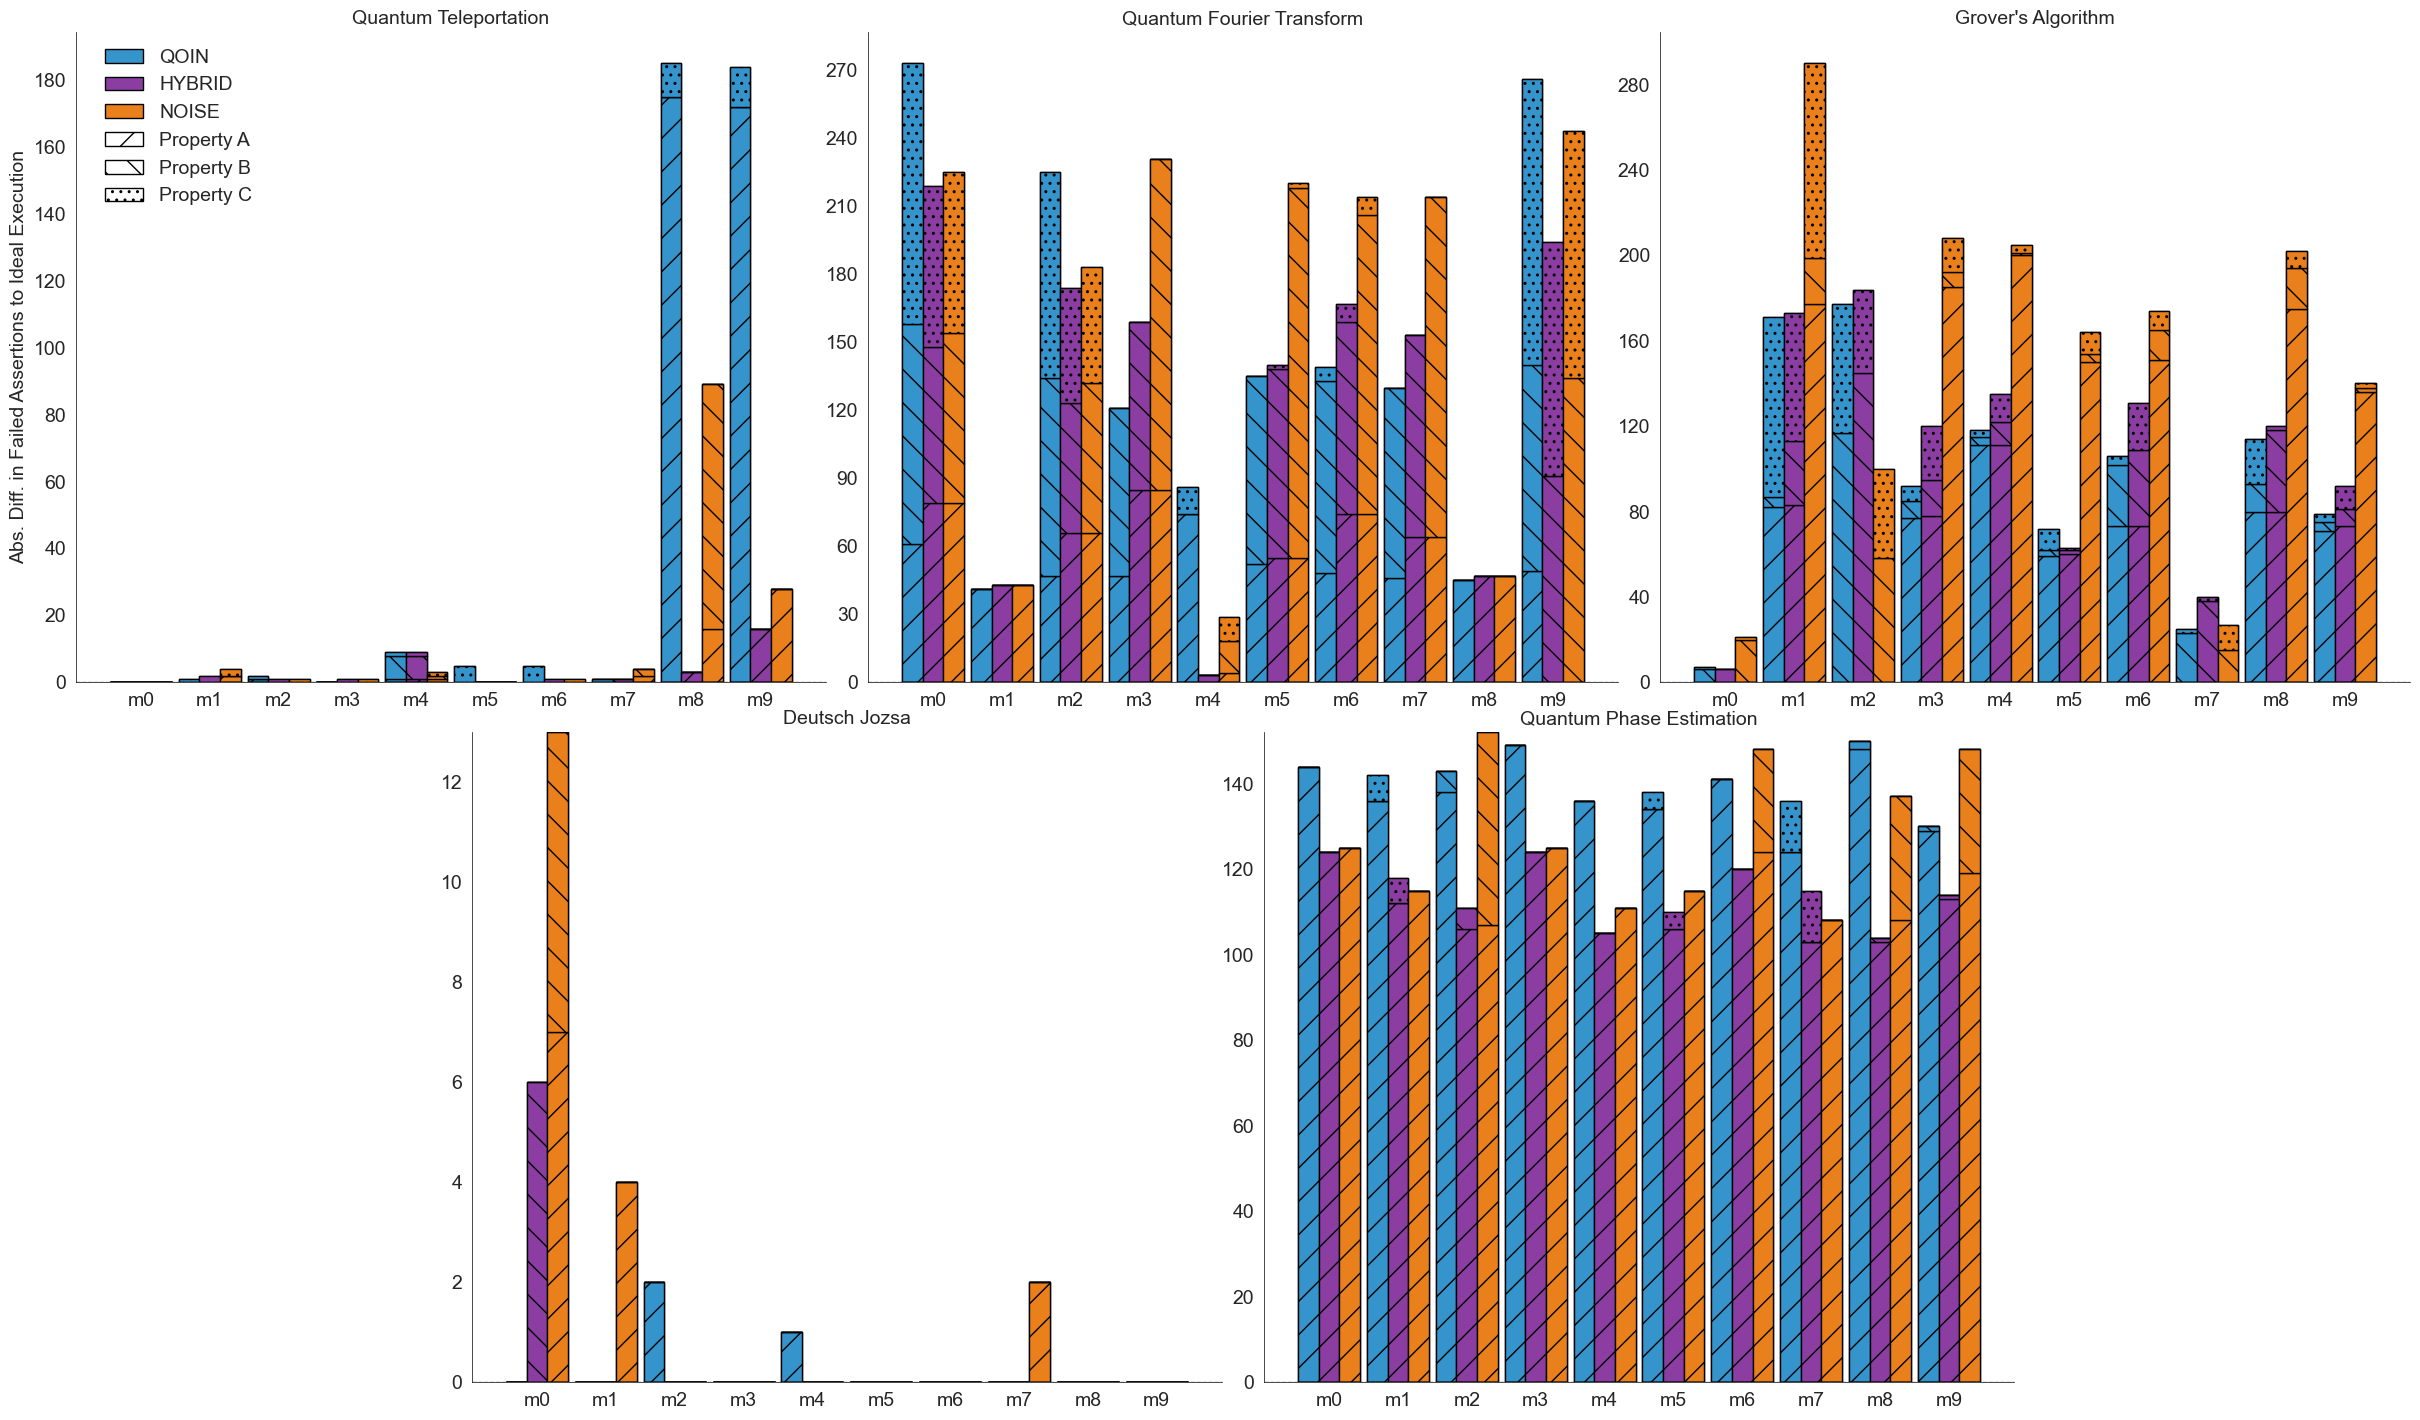

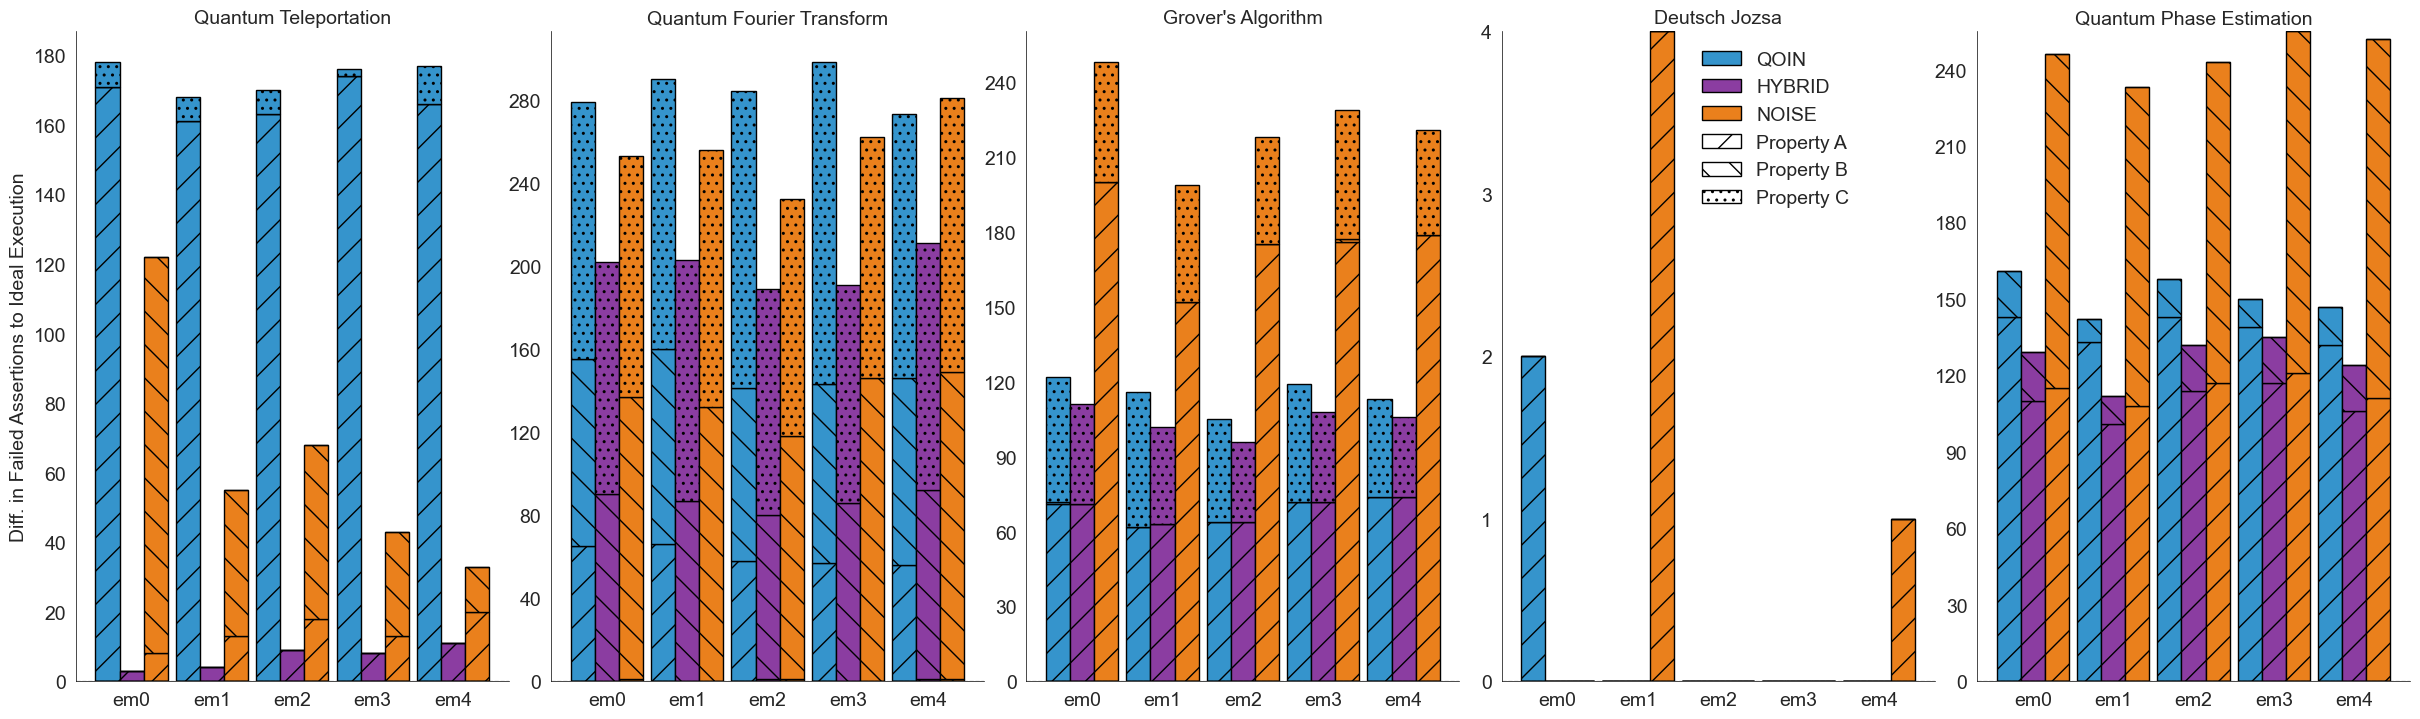

In [11]:
from matplotlib import gridspec

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Patch
import numpy as np

# -------------------------------
# Helper functions
# -------------------------------

def process_data(algorithm_name, desired_mode_order):
    """
    Reads the CSV for the given algorithm, parses the "Unique Failed Properties",
    computes per-mutant totals, pivots the table, and computes differences from the IDEAL baseline.
    Returns the pivoted DataFrame and the sorted list of property types.
    """
    suffix = "ALL_['id', 'sx', 'x', 'cz', 'rz']_quriFalse_clfTrue_merged_results"
    filename = f"mutation_test_results/{algorithm_name}/{algorithm_name}_{suffix}.csv"
    df = pd.read_csv(filename)

    # Parse the "Unique Failed Properties" into a dictionary.
    def parse_failed_properties(s):
        if pd.isna(s) or s.strip() == "":
            return {}
        d = {}
        for part in s.split(" & "):
            if ": " in part:
                prop, count_str = part.split(": ")
                try:
                    d[prop] = int(count_str)
                except ValueError:
                    d[prop] = 0
        return d

    df['failed_dict'] = df['Unique Failed Properties'].apply(parse_failed_properties)

    # Determine all property types that occur.
    property_types_set = set()
    for dct in df['failed_dict']:
        property_types_set.update(dct.keys())
    property_types = sorted(property_types_set)

    # Add numeric columns for each property type.
    for prop in property_types:
        df[prop] = df['failed_dict'].apply(lambda d: d.get(prop, 0))

    # Group by "Mutant Name" and "Mode" and sum the counts.
    grouped = df.groupby(['Mutant Name', 'Mode'])[property_types].sum().reset_index().rename(columns={})
    property_types = [col for col in grouped.columns if col not in ['Mutant Name', 'Mode']]

    # Pivot so that each mutant is a row with a multi-indexed column (mode, property).
    pivot_df = grouped.set_index(['Mutant Name', 'Mode'])[property_types].unstack(level='Mode', fill_value=0)
    pivot_df = pivot_df.swaplevel(axis=1)
    pivot_df = pivot_df.reindex(columns=desired_mode_order, level=0, fill_value=0)

    # Compute differences from the IDEAL baseline.
    if 'IDEAL' in pivot_df.columns.get_level_values(0):
        ideal_df = pivot_df['IDEAL']
        for mode in desired_mode_order:
            if mode != 'IDEAL' and mode in pivot_df.columns.get_level_values(0):
                pivot_df[mode] = pivot_df[mode].sub(ideal_df, fill_value=0)
        pivot_df = pivot_df.drop(columns='IDEAL', level=0)
        pivot_df = pivot_df.abs()
    else:
        print("Warning: IDEAL mode not found in data. No differences computed.")

    return pivot_df, property_types

def plot_group(ax, group_df, group_name, algorithm_name, mode_colours, desired_mode_order,
               property_types, property_hatches, show_ylabel=True):
    """
    Given an axis (ax) and the subset of data for one mutant group, plot the stacked bar chart.
    The individual mutant x-axis labels are added.
    (Note: The legend is not created here.)
    """
    # Identify modes (excluding IDEAL).
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    plot_modes = [mode for mode in desired_mode_order if mode != 'IDEAL' and mode in group_df.columns.get_level_values(0)]
    n_modes = len(plot_modes)
    if n_modes == 0:
        ax.text(0.5, 0.5, f"No data for {group_name}", ha="center", va="center")
        return

    mutants = group_df.index.tolist()
    n_mutants = len(mutants)
    bar_width = 0.9 / n_modes
    x = np.arange(n_mutants)

    # Draw a horizontal baseline at y=0.
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    # For each mode, draw stacked bars for each property.
    for mode_index, mode in enumerate(plot_modes):
        bar_positions = x + mode_index * bar_width
        data_mode = group_df[mode].copy()
        # Ensure every property exists in the data.
        for prop in property_types:
            if prop not in data_mode.columns:
                data_mode[prop] = 0

        pos_bottoms = np.zeros(n_mutants)
        neg_bottoms = np.zeros(n_mutants)
        for prop in property_types:
            values = data_mode[prop].values
            pos_values = np.where(values > 0, values, 0)
            neg_values = np.where(values < 0, values, 0)

            ax.bar(
                bar_positions,
                pos_values,
                width=bar_width,
                bottom=pos_bottoms,
                color=mode_colours.get(mode, '#333333'),
                edgecolor='black',
                linewidth=1,
                hatch=property_hatches.get(prop, '')
            )
            pos_bottoms += pos_values

            ax.bar(
                bar_positions,
                neg_values,
                width=bar_width,
                bottom=neg_bottoms,
                color=mode_colours.get(mode, '#333333'),
                edgecolor='black',
                linewidth=1,
                hatch=property_hatches.get(prop, '')
            )
            neg_bottoms += neg_values

    word = "Grover's"
    ax.set_title(f"{algorithm_name.replace('_',' ').title().replace('Grovers', word)}", fontsize=14)

    if show_ylabel:
        if group_name.startswith("EM"):
            ax.set_ylabel("Diff. in Failed Assertions to Ideal Execution", fontsize=14)
        elif group_name.startswith("M"):
            ax.set_ylabel("Abs. Diff. in Failed Assertions to Ideal Execution", fontsize=14)
    else:
        ax.set_ylabel("")

    ax.set_xticks(x + (n_modes - 1) * bar_width / 2)
    # Use sequential labels: "em0, em1, ..." for EM Mutants; "m0, m1, ..." for M Mutants.
    if group_name.startswith("EM"):
        tick_labels = [f"em{i}" for i in range(n_mutants)]
    else:
        tick_labels = [f"m{i}" for i in range(n_mutants)]
    ax.set_xticklabels(tick_labels, rotation=0, ha="center")
    ax.tick_params(labelsize=14)

    # Remove individual legends from each subplot.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['left'].set_color("black")
    ax.grid(False)

def plot_algorithms_separately(algorithms, mode_colours, desired_mode_order):
    """
    Creates two separate figures:
      - One for M Mutants (mutant names that contain '_m' but not '_em')
      - One for EM Mutants (mutant names that contain '_em')
    Each figure has one row of subplots (one per algorithm). A single, combined legend is added to each figure.
    """
    n_cols = len(algorithms)

    # Create figure for M Mutants using a 2x3 grid (6 slots) so that we have 3 on the top row and 2 on the bottom.
    fig_m = plt.figure(figsize=(24, 14))
    gs = gridspec.GridSpec(2, 6, figure=fig_m)

    axs_top = [
    fig_m.add_subplot(gs[0, 0:2]),
    fig_m.add_subplot(gs[0, 2:4]),
    fig_m.add_subplot(gs[0, 4:6])
    ]

    # Bottom row: two subplots in columns 2–3 and 4–5
    axs_bottom = [
        fig_m.add_subplot(gs[1, 1:3]),
        fig_m.add_subplot(gs[1, 3:5])
    ]

    # Combine the axes into one list.
    axs_m = axs_top + axs_bottom

    # Later, in your loop, use axs_m for each algorithm.
    for col, algo in enumerate(algorithms):
        try:
            pivot_df, property_types = process_data(algo, desired_mode_order)
        except Exception as e:
            axs_m[col].text(0.5, 0.5, f"Error processing {algo}", ha="center", va="center")
            continue

        hatch_patterns = ['/', '\\', '..']
        property_hatches = {prop: hatch_patterns[i % len(hatch_patterns)] for i, prop in enumerate(property_types)}
        m_mutants = [mut for mut in pivot_df.index if '_m' in mut and '_em' not in mut]
        df_m = pivot_df.loc[m_mutants] if m_mutants else None
        show_ylabel = (col == 0)

        if df_m is not None and not df_m.empty:
            plot_group(axs_m[col], df_m, "M Mutants", algo, mode_colours, desired_mode_order,
                       property_types, property_hatches, show_ylabel=show_ylabel)
        else:
            axs_m[col].text(0.5, 0.5, "No M Mutants", ha="center", va="center")
            axs_m[col].set_title(f"{algo.replace('_',' ').title()} - M Mutants")
            axs_m[col].grid(False)

    # Hide any extra axes if you have fewer algorithms than grid slots.
    for ax in axs_m[len(algorithms):]:
        ax.set_visible(False)


    # Create figure for EM Mutants.
    fig_em, axs_em = plt.subplots(1, n_cols, figsize=(24, 7), squeeze=False)
    axs_em = axs_em[0]

    # Variables to hold representative legend info for each group.
    rep_property_types_M = None
    rep_property_hatches_M = None
    rep_plot_modes_M = None

    rep_property_types_EM = None
    rep_property_hatches_EM = None
    rep_plot_modes_EM = None

    # Define hatch patterns for properties (cycle through patterns).
    hatch_patterns = ['/', '\\', '..']

    for col, algo in enumerate(algorithms):
        try:
            pivot_df, property_types = process_data(algo, desired_mode_order)
        except Exception as e:
            axs_m[col].text(0.5, 0.5, f"Error processing {algo}", ha="center", va="center")
            axs_em[col].text(0.5, 0.5, f"Error processing {algo}", ha="center", va="center")
            continue

        # Define property hatch mapping.
        property_hatches = {prop: hatch_patterns[i % len(hatch_patterns)] for i, prop in enumerate(property_types)}

        # Filter for M Mutants: names containing '_m' but not '_em'
        m_mutants = [mut for mut in pivot_df.index if '_m' in mut and '_em' not in mut]
        df_m = pivot_df.loc[m_mutants] if m_mutants else None

        # Filter for EM Mutants: names containing '_em'
        em_mutants = [mut for mut in pivot_df.index if '_em' in mut]
        df_em = pivot_df.loc[em_mutants] if em_mutants else None

        # Save representative legend info for M Mutants (if not already set).
        if df_m is not None and not df_m.empty and rep_property_types_M is None:
            rep_property_types_M = property_types
            rep_property_hatches_M = property_hatches
            rep_plot_modes_M = [mode for mode in desired_mode_order if mode != 'IDEAL' and mode in df_m.columns.get_level_values(0)]
        # Save representative legend info for EM Mutants (if not already set).
        if df_em is not None and not df_em.empty and rep_property_types_EM is None:
            rep_property_types_EM = property_types
            rep_property_hatches_EM = property_hatches
            rep_plot_modes_EM = [mode for mode in desired_mode_order if mode != 'IDEAL' and mode in df_em.columns.get_level_values(0)]

        # Only the leftmost subplot shows a y-axis label.
        show_ylabel = (col == 0)

        if df_m is not None and not df_m.empty:
            plot_group(axs_m[col], df_m, "M Mutants", algo, mode_colours, desired_mode_order,
                       property_types, property_hatches, show_ylabel=show_ylabel)
        else:
            axs_m[col].text(0.5, 0.5, "No M Mutants", ha="center", va="center")
            axs_m[col].set_title(f"{algo.replace('_',' ').title()} - M Mutants")
            axs_m[col].grid(False)

        if df_em is not None and not df_em.empty:
            plot_group(axs_em[col], df_em, "EM Mutants", algo, mode_colours, desired_mode_order,
                       property_types, property_hatches, show_ylabel=show_ylabel)
        else:
            axs_em[col].text(0.5, 0.5, "No EM Mutants", ha="center", va="center")
            axs_em[col].set_title(f"{algo.replace('_',' ').title()} - EM Mutants")
            axs_em[col].grid(False)

    # Create a single, combined legend for the M Mutants figure.
    if rep_property_types_M is not None:
        mode_legend_M = [Patch(facecolor=mode_colours[m], edgecolor='black', label=m) for m in rep_plot_modes_M]
        # Use fixed labels "Property A", "Property B", "Property C" for the first three properties.
        property_labels_fixed = ["Property A", "Property B", "Property C"]
        property_legend_M = [Patch(facecolor='white', edgecolor='black', hatch=rep_property_hatches_M[p], label=property_labels_fixed[i])
                             for i, p in enumerate(rep_property_types_M) if i < len(property_labels_fixed)]
        combined_legend_M = mode_legend_M + property_legend_M
        fig_m.legend(handles=combined_legend_M, loc=(0.04, 0.85), frameon=False, fontsize=14)

    # Create a single, combined legend for the EM Mutants figure.
    if rep_property_types_EM is not None:
        mode_legend_EM = [Patch(facecolor=mode_colours[m], edgecolor='black', label=m) for m in rep_plot_modes_EM]
        property_labels_fixed = ["Property A", "Property B", "Property C"]
        property_legend_EM = [Patch(facecolor='white', edgecolor='black', hatch=rep_property_hatches_EM[p], label=property_labels_fixed[i])
                              for i, p in enumerate(rep_property_types_EM) if i < len(property_labels_fixed)]
        combined_legend_EM = mode_legend_EM + property_legend_EM
        fig_em.legend(handles=combined_legend_EM, loc=(0.7, 0.7), frameon=False, fontsize=14)

    fig_m.suptitle(None)
    # fig_m.suptitle("M Mutants", fontsize=16)
    # fig_em.suptitle("EM Mutants", fontsize=16)
    fig_em.suptitle(None)
    # fig_m.tight_layout(rect=[0, 0, 1, 0.95])
    fig_m.tight_layout(pad=0)
    fig_em.tight_layout(pad=0)
    # fig_em.tight_layout(rect=[0, 0, 1, 0.95])

    # Save the figures if needed.
    fig_m.savefig("failed-assertions-M.svg", dpi=300, bbox_inches='tight')
    fig_em.savefig("failed-assertions-EM.svg", dpi=300, bbox_inches='tight')

    plt.show()

# -------------------------------
# Settings and function call
# -------------------------------

mode_colours = {
    'HYBRID': '#8B3DA1',
    'QOIN': '#3594cc',
    'IDEAL': '#f0b077',
    'NOISE': '#ea801c'
}

desired_mode_order = ['IDEAL', 'QOIN', 'HYBRID', 'NOISE']

algorithms = [
    "quantum_teleportation",
    "quantum_fourier_transform",
    "grovers_algorithm",
    "deutsch_jozsa",
    "quantum_phase_estimation"
]

# Increase hatch linewidth to make hatching more pronounced.
plt.rcParams['hatch.linewidth'] = 1

# Create the two separate figures.
plot_algorithms_separately(algorithms, mode_colours, desired_mode_order)


Statistics per Algorithm and Measurement:
                    Algorithm Measurement      mean    median       std       max       min
0              Deutsch Jozsa       Noise  0.080681  0.095083  0.074769  0.290821  0.000000
1              Deutsch Jozsa        Qoin  0.004242  0.000000  0.007050  0.150295  0.000000
2         Grover's Algorithm       Noise  0.126345  0.050728  0.152307  0.720040  0.000000
3         Grover's Algorithm        Qoin  0.073136  0.006600  0.145317  0.818751  0.000000
4  Quantum Fourier Transform       Noise  0.158470  0.140490  0.123280  0.660815  0.001746
5  Quantum Fourier Transform        Qoin  0.169919  0.123478  0.156252  0.868155  0.000000
6   Quantum Phase Estimation       Noise  0.063060  0.027697  0.075578  0.432887  0.000000
7   Quantum Phase Estimation        Qoin  0.034836  0.016561  0.048507  0.312308  0.000000
8      Quantum Teleportation       Noise  0.055422  0.026728  0.060727  0.243717  0.000000
9      Quantum Teleportation        Qoin  0.047

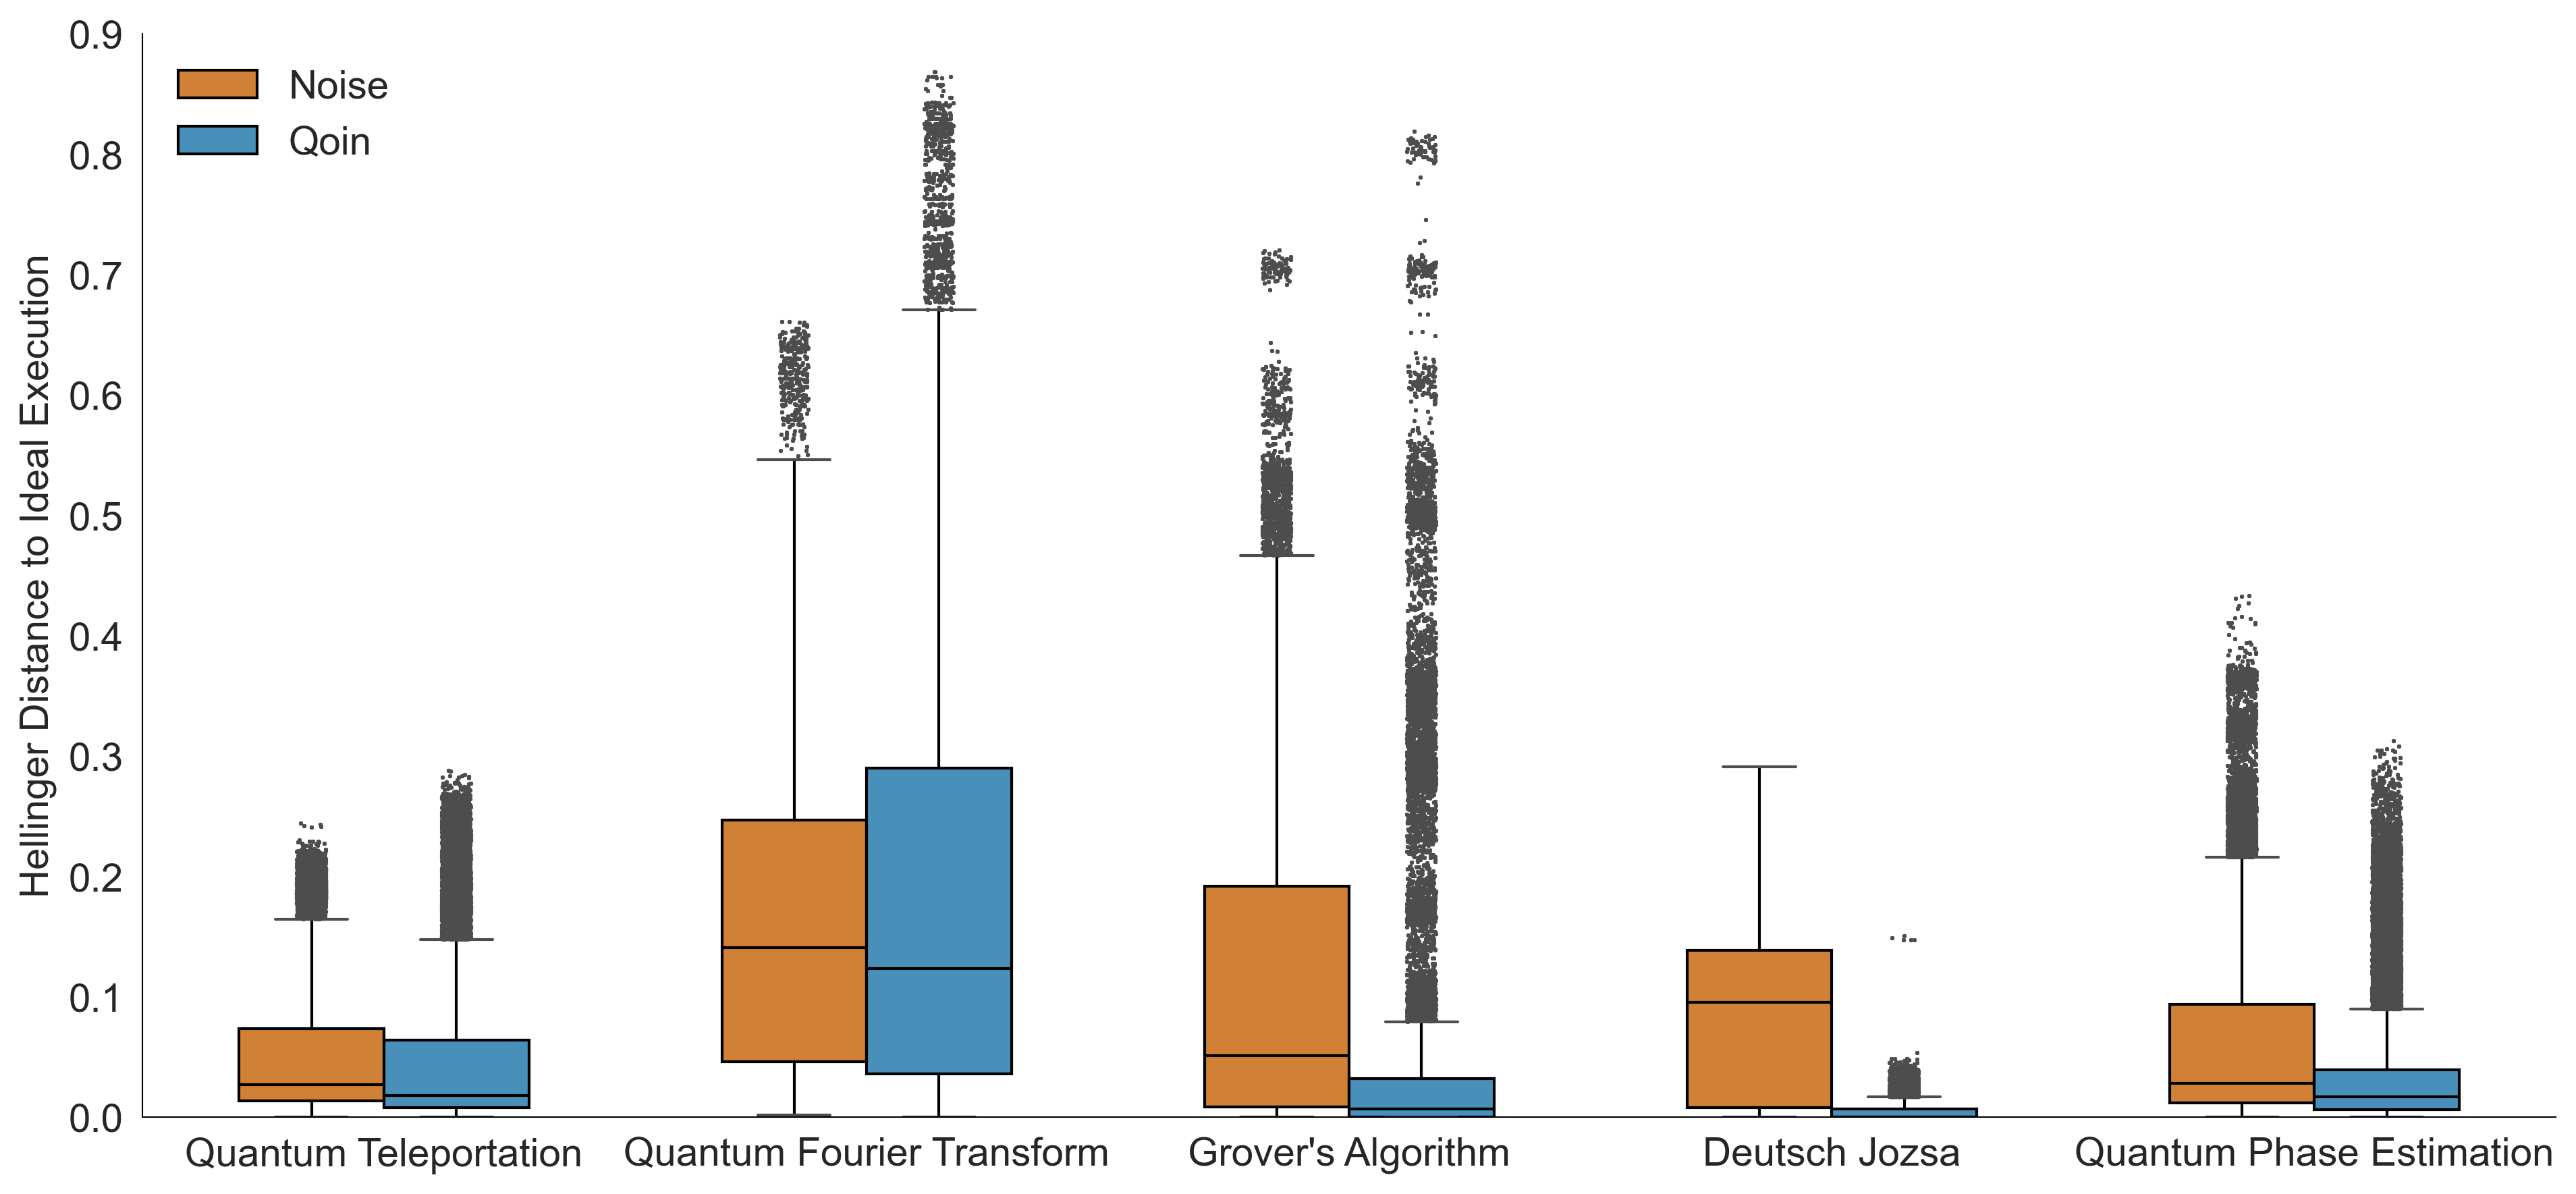

In [12]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def distances_boxplot(df_dict):
    fig, ax = plt.subplots(figsize=(13, 6), dpi=300)
    colors = {"Noise": "#ea801c", "Qoin": "#3594cc"}

    df_list = []
    for algorithm_name, df in df_dict.items():
        clean_name = algorithm_name.replace("_", " ").title()
        clean_name = clean_name.replace("Grovers", "Grover's")

        all_noise_distances = list(itertools.chain.from_iterable(df["noise_dist_flat"]))
        all_qoin_distances  = list(itertools.chain.from_iterable(df["qoin_dist_flat"]))

        df_long = pd.DataFrame({
            "Algorithm": [clean_name] * (len(all_noise_distances) + len(all_qoin_distances)),
            "Distance": all_noise_distances + all_qoin_distances,
            "Measurement": ["Noise"] * len(all_noise_distances) + ["Qoin"] * len(all_qoin_distances)
        })

        df_list.append(df_long)

    df_combined = pd.concat(df_list, ignore_index=True)

    # Compute statistics per algorithm and per measurement
    stats_per_algorithm_measurement = df_combined.groupby(["Algorithm", "Measurement"])["Distance"].agg(["mean", "median", "std", "max", "min"]).reset_index()
    print("Statistics per Algorithm and Measurement:\n", stats_per_algorithm_measurement)

    # Compute overall statistics per measurement
    overall_stats = df_combined.groupby("Measurement")["Distance"].agg(["mean", "median", "std", "max", "min"]).reset_index()
    print("Overall Statistics per Measurement:\n", overall_stats)

    sns.boxplot(
        x="Algorithm",
        y="Distance",
        hue="Measurement",
        data=df_combined,
        palette=colors,
        showfliers=True,
        width=0.6,  # Reduced width of the boxes
        boxprops={'edgecolor': "black"},
        whiskerprops={'color': "black"},
        medianprops={'color': "black"},
        flierprops={
            'marker': "$.$",
            'color': 'red',
            'markersize': 0.5,
            'alpha': 1
        },
        ax=ax
    )

    for l in ax.lines:
        if l.get_marker() != '':
            xs = l.get_xdata()
            xs += np.random.uniform(-0.03, 0.03, len(xs))
            l.set_xdata(xs)

    ax.set_xlabel("")
    ax.set_ylabel("Hellinger Distance to Ideal Execution", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['left'].set_color("black")
    ax.legend(loc="upper left", fontsize=14, title_fontsize=14, frameon=False)
    ax.grid(False)
    ax.set_ylim(0, 0.9)

    plt.tight_layout()
    plt.savefig("hel-dist-to-ideal.svg", dpi=300, bbox_inches='tight')
    plt.show()


df_dict = {
    "quantum_teleportation": df_qt,
    "quantum_fourier_transform": df_qft,
    "grovers_algorithm": df_ga,
    "deutsch_jozsa": df_dj,
    "quantum_phase_estimation": df_qpe
}

distances_boxplot(df_dict)


  Property  Distance Measurement
0     QT B  0.459713       Noise
=====
Property
QT B    18000
Name: count, dtype: int64
===== 

iteration 0
props  18000
ctr  0
dist 6000
----------- ilocs --------------
Property           QT B
Distance       0.459713
Measurement       Noise
Name: 0, dtype: object
Property           QT B
Distance       0.532036
Measurement        QOIN
Name: 6000, dtype: object
Property           QT B
Distance       0.553804
Measurement       Ideal
Name: 12000, dtype: object
Property             QT B
NoiseDistance    0.459713
QOINDistance     0.532036
IdealDistance    0.553804
Name: 0, dtype: object
     Property  NoiseDistance  QOINDistance  IdealDistance
0        QT B       0.459713      0.532036       0.553804
1        QT B       0.018355      0.011937       0.009384
2        QT B       0.048545      0.063457       0.047417
3        QT B       0.448244      0.537492       0.542285
4        QT B       0.020933      0.009601       0.018959
...       ...            ... 

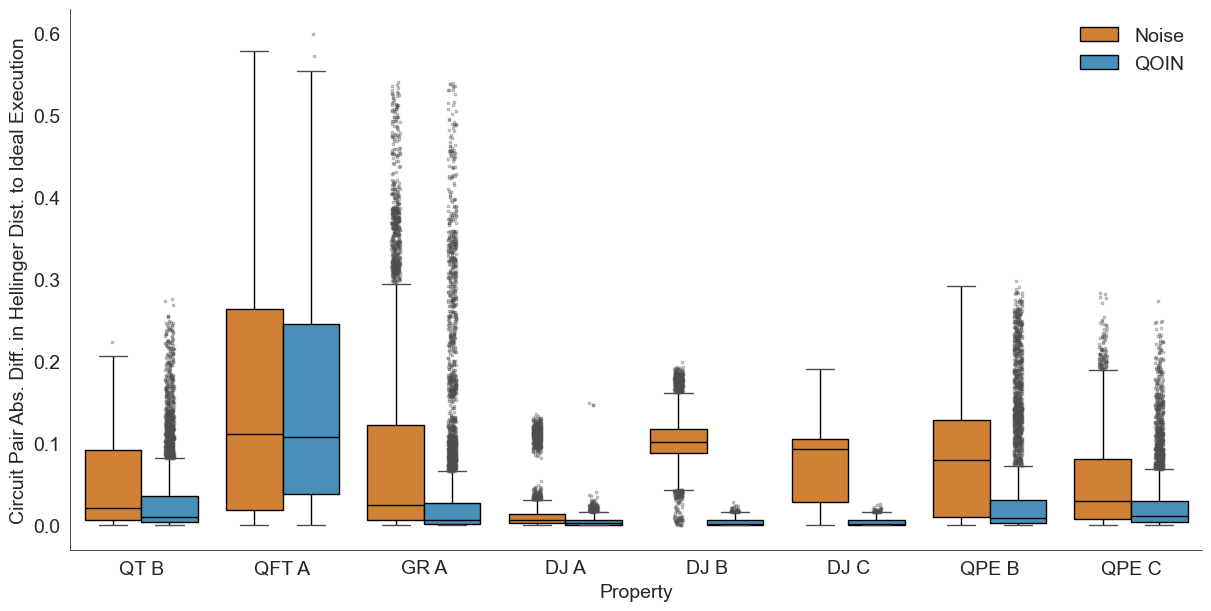

(<Figure size 1200x600 with 1 Axes>,
 <Axes: xlabel='Property', ylabel='Circuit Pair Abs. Diff. in Hellinger Dist. to Ideal Execution'>)

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Needed for np.random.uniform


def recursive_flatten(item):
    """Recursively flatten a nested list."""
    if isinstance(item, list):
        for subitem in item:
            yield from recursive_flatten(subitem)
    else:
        yield item

def return_properties(df):
    """
    Extract property names from columns starting with 'noise_pvals_'
    (ignoring any property that becomes 'flat').
    """
    props = [col.replace("noise_pvals_", "")
             for col in df.columns
             if col.startswith("noise_pvals_") and col.replace("noise_pvals_", "").lower() != "flat"]
    return props, props

def get_numeric_properties(df):
    """
    Returns a list of properties that are determined to be numeric.
    Boolean properties (or those whose sample value appears as a boolean)
    are excluded.
    """
    props, _ = return_properties(df)
    numeric_properties = []

    for prop in props:
        def get_first_value(prefix):
            col = f"{prefix}_dist_eq_{prop}"
            if col in df.columns:
                for item in df[col].dropna():
                    for val in recursive_flatten(item):
                        return val
            return None

        # Check noise first, then qoin.
        value_found = get_first_value("noise") or get_first_value("qoin")
        # If the value is a boolean or a string boolean, skip (i.e. do not add to numeric_properties)
        if value_found is not None and (isinstance(value_found, bool) or
           (isinstance(value_found, str) and value_found.lower() in ["true", "false"])):
            continue
        else:
            numeric_properties.append(prop)

    # print(f"1 {numeric_properties}")
    return numeric_properties

def build_long_df_for_numeric(df_subset, numeric_properties, selected_properties):
    """
    Build a long-format DataFrame (one row per p‑value) for numeric properties
    from the given subset of the DataFrame.
    """
    # print(f"2 {numeric_properties}")
    rows = []
    for prop in numeric_properties:
        # print(len(rows))
        # Clean up the property name for display.
        # print(prop)
        # prop_label = prop.replace("_", " ").title()
        prop_label = property_names_[prop]
        if prop_label in selected_properties:
            # Loop over the three measurement types.
            for meas, prefix in zip(["Noise", "Qoin", "id"], ["noise", "qoin", "id"]):
                col = f"{prefix}_dist_eq_{prop}"
                if col in df_subset.columns:
                    for item in df_subset[col].dropna():
                        for val in recursive_flatten(item):
                            rows.append({
                                "Property": prop_label,
                                "Distance": val,
                                "Measurement": meas
                            })

    return pd.DataFrame(rows)

def compute_differences(df):
    # Ensure we have only the three scenarios we care about
    valid_measurements = ["QOIN", "Noise", "Ideal"]
    df = df[df["Measurement"].isin(valid_measurements)].copy()

    new_df = pd.DataFrame(columns=["Property", "NoiseDistance", "QOINDistance", "IdealDistance"])

    len_ea = df["Property"].value_counts()[0]

    print("=====")
    print(df["Property"].value_counts())
    print("===== \n")

    ctr = 0

    for i, props in enumerate(df["Property"].value_counts()):
        dist = (props)//3
        print(f"iteration {i}")
        print(f"props  {props}")
        print(f"ctr  {ctr}")
        print(f"dist {dist}")

        for idx in range(dist):
            new_df.loc[len(new_df)] = [df.iloc[idx + ctr]["Property"], df.iloc[idx + ctr]["Distance"], df.iloc[idx + dist + ctr]["Distance"], df.iloc[idx + (dist*2) + ctr]["Distance"]]

        print("----------- ilocs --------------")
        print(df.iloc[0 + ctr])
        print(df.iloc[dist + ctr])
        print(df.iloc[2*dist + ctr])
        print(new_df.iloc[ctr//3])
        ctr += props

    print(new_df)
    print(new_df["IdealDistance"] - new_df["NoiseDistance"])
    new_df["Noise"] = (new_df["IdealDistance"] - new_df["NoiseDistance"]).abs()
    print(new_df["IdealDistance"] - new_df["QOINDistance"])
    new_df["QOIN"] = (new_df["IdealDistance"] - new_df["QOINDistance"]).abs()

    new_df2 = new_df[["Property", "Noise"]]
    new_df2 = new_df2.rename(columns={"Noise":"Distance"})
    new_df2["Measurement"] = "Noise"
    new_df3 = new_df[["Property", "QOIN"]]
    new_df3 = new_df3.rename(columns={"QOIN":"Distance"})
    new_df3["Measurement"] = "QOIN"

    return pd.concat([new_df2, new_df3])


def plot_box(ax, data, title, colors):
    """
    Helper function to create a styled boxplot on a given axis.
    """
    sns.boxplot(
        x="Property",
        y="Distance",
        hue="Measurement",
        data=data,
        palette=colors,
        showfliers=True,
        width=0.8,
        boxprops={'edgecolor': "black"},
        whiskerprops={'color': "black"},
        medianprops={'color': "black"},
        flierprops={
            'marker': "$.$",
            'color': 'red',
            'markersize': 0.9,
            'alpha': 0.4
        },
        ax=ax
    )

    # Jitter flier points slightly in x:
    for l in ax.lines:
        if l.get_marker() != '':
            xs = l.get_xdata()
            xs += np.random.uniform(-0.03, 0.03, len(xs))
            l.set_xdata(xs)

    # Adjust plot range if desired
    # ax.set_ylim(-0.1, 1.02)  # For example, you can change lower bound to show negative diffs
    # ax.set_title(title, fontsize=14)


def plot_all_in_one(
    data_dict,
    selected_properties=None,
    save_path="hel-dist-pairs.svg",
    eq=None
):
    """
    Create a figure showing differences instead of raw distances:
      - QOIN_minus_Ideal
      - Noise_minus_Ideal
    """
    # Colors for the difference 'Measurement' categories:
    # colors = {
    #     "QOIN_minus_Ideal": "#3594cc",
    #     "Noise_minus_Ideal": "#ea801c"
    # }
    colors = {
        "QOIN": "#3594cc",
        "Noise": "#ea801c"
    }

    # -----------------------
    # 1) Combine all data
    # -----------------------
    all_data_m = []
    all_data_em = []

    for algo_name, df in data_dict.items():
        # Determine numeric properties in this df
        numeric_props = get_numeric_properties(df)

        # Subset for M and EM
        df_m  = df[df["mutant_type"].str.lower() == "m"]
        df_em = df[df["mutant_type"].str.lower() == "em"]

        # Build the long data as before
        df_m_long  = build_long_df_for_numeric(df_m,  numeric_props, selected_properties)
        df_em_long = build_long_df_for_numeric(df_em, numeric_props, selected_properties)

        # long dif will be problem! - multiple props
        print(df_m_long.head(1))

        if df_m_long.size > 0:

            # Rename "Qoin" -> "QOIN", "id" -> "Ideal"
            rename = {"Qoin": "QOIN", "id": "Ideal"}
            df_m_long["Measurement"]  = df_m_long["Measurement"].replace(rename)
            df_em_long["Measurement"] = df_em_long["Measurement"].replace(rename)

            # print(df_m_long)

            # --- NEW STEP: convert from raw distances to difference-based distances
            df_m_diff  = compute_differences(df_m_long)
            df_em_diff = compute_differences(df_em_long)

            # Accumulate
            all_data_m.append(df_m_diff)
            all_data_em.append(df_em_diff)

    # Concatenate for M and EM
    all_data_m  = pd.concat(all_data_m , ignore_index=True)
    all_data_em = pd.concat(all_data_em, ignore_index=True)

    # Create figure
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        figsize=(12, 6),
        constrained_layout=True,
        sharey=True
    )

    if eq == False:
        # Plot M
        if not all_data_m.empty:
            plot_box(ax, all_data_m, "All Algorithms - M (Differences)", colors)
        else:
            ax.axis('off')
    else:
        # Plot EM
        if not all_data_em.empty:
            plot_box(ax, all_data_em, "All Algorithms - EM (Differences)", colors)
        else:
            ax.axis('off')

    ax.set_xlabel("Property", fontsize=14)
    ax.set_ylabel("Circuit Pair Abs. Diff. in Hellinger Dist. to Ideal Execution", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['left'].set_color("black")

    ax.legend(
        loc="upper right",
        fontsize=14,
        title_fontsize=14,
        frameon=False
    )
    ax.grid(False)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return fig, ax


data_dict = {
    "quantum_teleportation": df_qt,
    "quantum_fourier_transform": df_qft,
    "grovers_algorithm": df_ga,
    "deutsch_jozsa": df_dj,
    "quantum_phase_estimation": df_qpe
}

selected_props = ["QT B", "QFT A", "GR A", "QPE B", "QPE C", "DJ A", "DJ B", "DJ C"]
plot_all_in_one(data_dict, selected_properties=selected_props, save_path="hel-dist-pairs-neq-qoin.svg", eq=False)

  Property  Distance Measurement
0     QT A  0.183643       Noise
=====
Property
QT A    18000
QT C    18000
Name: count, dtype: int64
===== 

iteration 0
props  18000
ctr  0
dist 6000
----------- ilocs --------------
Property           QT A
Distance       0.183643
Measurement       Noise
Name: 0, dtype: object
Property           QT A
Distance       0.207221
Measurement        QOIN
Name: 6000, dtype: object
Property          QT A
Distance       0.19911
Measurement      Ideal
Name: 12000, dtype: object
Property             QT A
NoiseDistance    0.183643
QOINDistance     0.207221
IdealDistance     0.19911
Name: 0, dtype: object
iteration 1
props  18000
ctr  18000
dist 6000
----------- ilocs --------------
Property           QT C
Distance       0.469944
Measurement       Noise
Name: 18000, dtype: object
Property           QT C
Distance       0.607634
Measurement        QOIN
Name: 24000, dtype: object
Property           QT C
Distance       0.514003
Measurement       Ideal
Name: 30000, dtyp

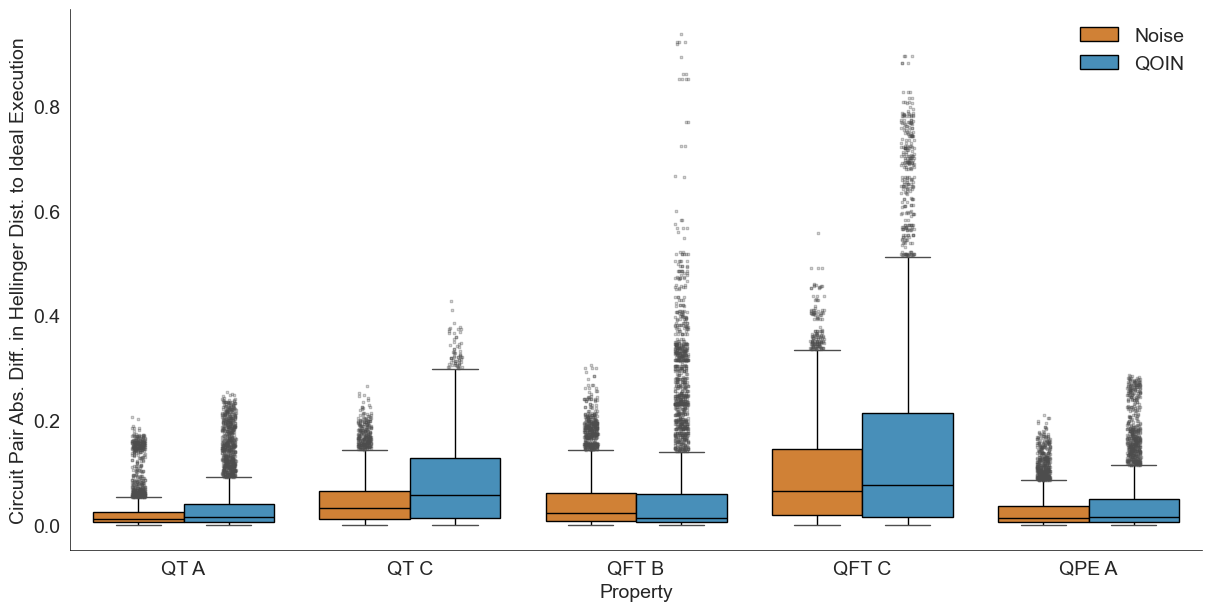

(<Figure size 1200x600 with 1 Axes>,
 <Axes: xlabel='Property', ylabel='Circuit Pair Abs. Diff. in Hellinger Dist. to Ideal Execution'>)

In [14]:
selected_props = ["QT A", "QT C", "QFT B", "QFT C", "QPE A"]
plot_all_in_one(data_dict, selected_properties=selected_props, save_path="hel-dist-pairs-neq-noise.svg", eq=False)

  Property  Distance Measurement
0     QT B  0.459713       Noise
=====
Property
QT B    18000
QT C    18000
Name: count, dtype: int64
===== 

iteration 0
props  18000
ctr  0
dist 6000
----------- ilocs --------------
Property           QT B
Distance       0.459713
Measurement       Noise
Name: 0, dtype: object
Property           QT B
Distance       0.532036
Measurement        QOIN
Name: 6000, dtype: object
Property           QT B
Distance       0.553804
Measurement       Ideal
Name: 12000, dtype: object
Property             QT B
NoiseDistance    0.459713
QOINDistance     0.532036
IdealDistance    0.553804
Name: 0, dtype: object
iteration 1
props  18000
ctr  18000
dist 6000
----------- ilocs --------------
Property           QT C
Distance       0.469944
Measurement       Noise
Name: 18000, dtype: object
Property           QT C
Distance       0.607634
Measurement        QOIN
Name: 24000, dtype: object
Property           QT C
Distance       0.514003
Measurement       Ideal
Name: 30000, d

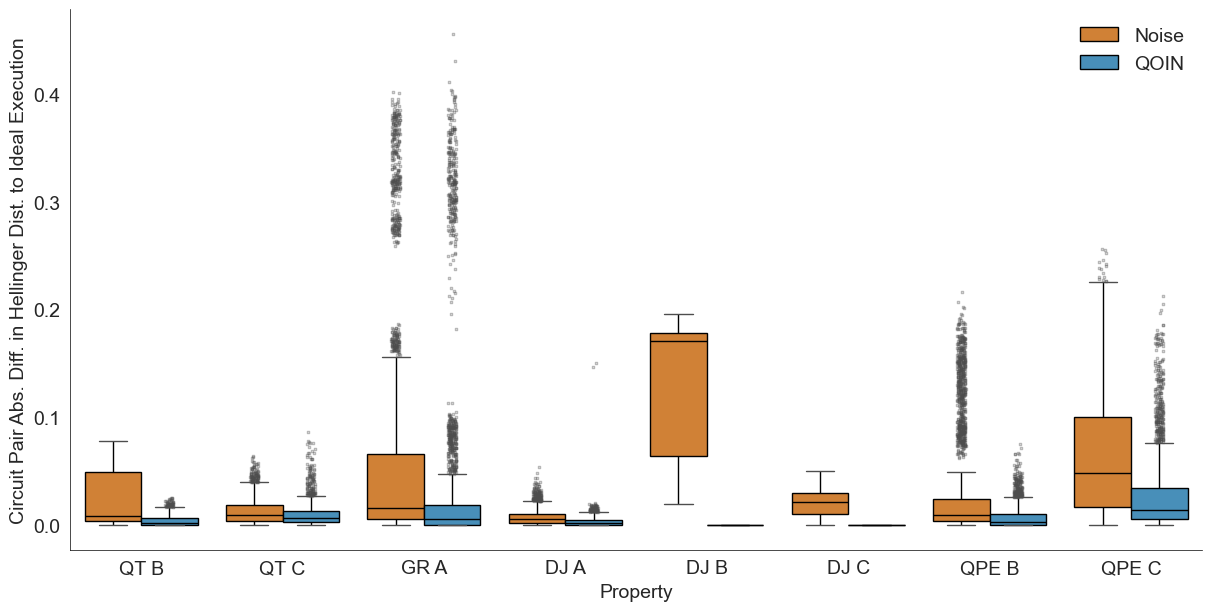

(<Figure size 1200x600 with 1 Axes>,
 <Axes: xlabel='Property', ylabel='Circuit Pair Abs. Diff. in Hellinger Dist. to Ideal Execution'>)

In [15]:
selected_props = ["QT B", "QT C", "GR A", "QPE B", "QPE C", "DJ A", "DJ B", "DJ C"]
plot_all_in_one(data_dict, selected_properties=selected_props, save_path="hel-dist-pairs-eq-qoin.svg", eq=True)

  Property  Distance Measurement
0     QT A  0.183643       Noise
=====
Property
QT A    18000
Name: count, dtype: int64
===== 

iteration 0
props  18000
ctr  0
dist 6000
----------- ilocs --------------
Property           QT A
Distance       0.183643
Measurement       Noise
Name: 0, dtype: object
Property           QT A
Distance       0.207221
Measurement        QOIN
Name: 6000, dtype: object
Property          QT A
Distance       0.19911
Measurement      Ideal
Name: 12000, dtype: object
Property             QT A
NoiseDistance    0.183643
QOINDistance     0.207221
IdealDistance     0.19911
Name: 0, dtype: object
     Property  NoiseDistance  QOINDistance  IdealDistance
0        QT A       0.183643      0.207221       0.199110
1        QT A       0.359972      0.419171       0.407862
2        QT A       0.029814      0.042643       0.068001
3        QT A       0.488838      0.629384       0.535663
4        QT A       0.025947      0.052540       0.041769
...       ...            ...    

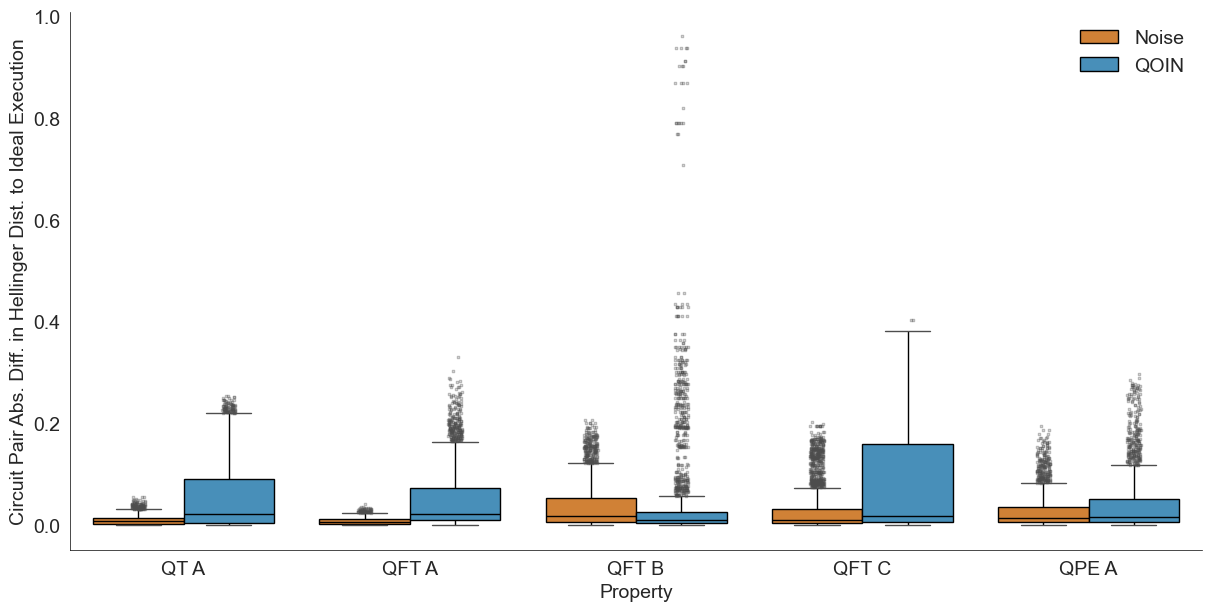

(<Figure size 1200x600 with 1 Axes>,
 <Axes: xlabel='Property', ylabel='Circuit Pair Abs. Diff. in Hellinger Dist. to Ideal Execution'>)

In [16]:
selected_props = ["QT A", "QFT A", "QFT B", "QFT C", "QPE A"]
plot_all_in_one(data_dict, selected_properties=selected_props, save_path="hel-dist-pairs-eq-noise.svg", eq=True)

1% and 0.1% high and low

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def recursive_flatten(item):
    """Recursively flatten a nested list."""
    if isinstance(item, list):
        for subitem in item:
            yield from recursive_flatten(subitem)
    else:
        yield item

def return_properties(df):
    """Return a list of properties based on columns starting with 'noise_pvals_' (excluding 'flat')."""
    props = [col.replace("noise_pvals_", "")
             for col in df.columns
             if col.startswith("noise_pvals_") and col.replace("noise_pvals_", "").lower() != 'flat']
    return props, props

def pvals_violin_plot(df, algorithm_name):
    colors = {"Noise": "#ea801c", "Qoin": "#3594cc", "id": "#8cc5e3"}
    property_pvals_noise, _ = return_properties(df)
    all_properties = property_pvals_noise

    numeric_properties, boolean_properties = [], []

    def get_first_value(df, prefix, prop):
        """Return the first flattened value found in the specified column."""
        col = f"{prefix}_dist_eq_{prop}"
        if col in df.columns:
            for item in df[col].dropna():
                for val in recursive_flatten(item):
                    return val
        return None

    # Determine property types by checking for a sample value.
    for prop in all_properties:
        value_found = get_first_value(df, "noise", prop) or get_first_value(df, "qoin", prop)
        if value_found is not None and (isinstance(value_found, bool) or
           (isinstance(value_found, str) and value_found.lower() in ["true", "false"])):
            boolean_properties.append(prop)
        else:
            numeric_properties.append(prop)

    def get_property_pvals(df_subset, prefix, prop):
        """Extract and fully flatten the values for a given property and prefix."""
        col = f"{prefix}_dist_eq_{prop}"
        return [val for item in df_subset[col].dropna() for val in recursive_flatten(item)]

    if numeric_properties:
        # Split the data by mutant type.
        df_em = df[df["mutant_type"].str.lower() == "em"]
        df_m  = df[df["mutant_type"].str.lower() == "m"]

        def build_long_df(df_subset):
            """Build a long-format DataFrame (one row per p‑value) for numeric properties."""
            rows = []
            for prop in numeric_properties:
                prop_label = prop.replace("_", " ").title()
                print(f"{prop_label}")
                for meas, prefix in zip(["Noise", "Ideal", "Qoin",], ["noise", "id", "qoin"]):
                    r2 = []
                    for val in get_property_pvals(df_subset, prefix, prop):
                        r2.append({"Property": prop_label, "Distance": val, "Measurement": meas})
                        rows.append({"Property": prop_label, "Distance": val, "Measurement": meas})
                    r2 = pd.DataFrame(r2)
                    print(f"--- {meas} ---")
                    if 'Distance' not in r2 or r2['Distance'].dtype == 'bool':
                        continue
                    q99 = r2['Distance'].quantile(0.99)
                    q999 = r2['Distance'].quantile(0.999)
                    q1 = r2['Distance'].quantile(0.01)
                    q01 = r2['Distance'].quantile(0.001)
                    print(f"0.1% low {float(f'{q01:.3g}')}")
                    print(f"1% low {float(f'{q1:.3g}')}")
                    print(f"1% high {float(f'{q99:.3g}')}")
                    print(f"0.1% high {float(f'{q999:.3g}')}")

            return pd.DataFrame(rows)

        print("======== Non Equiv Mutants =========")
        df_m_long  = build_long_df(df_m)
        print("======== Equiv Mutants =========")
        df_em_long = build_long_df(df_em)

# Example calls (uncomment and supply your actual DataFrames):
pvals_violin_plot(df_qt, "quantum_teleportation")
pvals_violin_plot(df_qft, "quantum_fourier_transform")
pvals_violin_plot(df_ga, "grovers_algorithm")
pvals_violin_plot(df_dj, "deutsch_jozsa")
pvals_violin_plot(df_qpe, "quantum_phase_estimation")

======== Non Equiv Mutants =========
Inq0Equaloutq2
--- Noise ---
0.1% low 0.0
1% low 0.000476
1% high 0.671
0.1% high 0.766
--- Ideal ---
0.1% low 0.0
1% low 0.000275
1% high 0.783
0.1% high 0.94
--- Qoin ---
0.1% low 0.0
1% low 0.0
1% high 0.859
0.1% high 1.0
Notteleportedplus
--- Noise ---
0.1% low 0.00331
1% low 0.00546
1% high 0.811
0.1% high 0.819
--- Ideal ---
0.1% low 0.0
1% low 0.0
1% high 1.0
0.1% high 1.0
--- Qoin ---
0.1% low 0.0
1% low 0.0
1% high 1.0
0.1% high 1.0
Unitarybeforeandafterteleport
--- Noise ---
0.1% low 0.0105
1% low 0.0144
1% high 0.662
0.1% high 0.744
--- Ideal ---
0.1% low 0.000239
1% low 0.00287
1% high 0.829
0.1% high 0.943
--- Qoin ---
0.1% low 0.0
1% low 0.00173
1% high 1.0
0.1% high 1.0
======== Equiv Mutants =========
Inq0Equaloutq2
--- Noise ---
0.1% low 0.0
1% low 0.000237
1% high 0.048
0.1% high 0.057
--- Ideal ---
0.1% low 0.0
1% low 0.0
1% high 0.0233
0.1% high 0.0282
--- Qoin ---
0.1% low 0.0
1% low 0.0
1% high 0.242
0.1% high 0.255
Notteleport

EMD calculations

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance, ks_2samp
from scipy.spatial.distance import jensenshannon

def recursive_flatten(x):
    """Assumed helper function that recursively flattens nested lists/tuples."""
    if isinstance(x, (list, tuple)):
        for item in x:
            yield from recursive_flatten(item)
    else:
        yield x

def flatten_col_values(series):
    """
    Flattens all nested lists/tuples in a pandas Series into a single list of values.
    Uses the recursive_flatten function.
    """
    values = []
    for item in series.dropna():
        for val in recursive_flatten(item):
            values.append(val)
    return values

def get_numeric_properties(df):
    """
    Returns a list of properties that are determined to be numeric.
    Boolean properties (or those whose sample value appears as a boolean)
    are excluded.
    """
    props, _ = return_properties(df)
    numeric_properties = []

    for prop in props:
        def get_first_value(prefix):
            col = f"{prefix}_dist_eq_{prop}"
            if col in df.columns:
                for item in df[col].dropna():
                    for val in recursive_flatten(item):
                        return val
            return None

        # Check noise first, then qoin.
        value_found = get_first_value("noise") or get_first_value("qoin")
        print(value_found)
        # If the value is a boolean or a string boolean, skip (i.e. do not add to numeric_properties)
        if value_found is None:
            continue
        else:
            numeric_properties.append(prop)

    return numeric_properties

def compute_jensen_shannon_distance(list1, list2, bins=50):
    """
    Computes the Jensen–Shannon distance between two lists of values.
    We first convert the lists into probability distributions using histograms over a common range.
    Returns None if either list is empty.
    """
    if len(list1) == 0 or len(list2) == 0:
        return None

    # Define common range based on the combined data
    combined = list1 + list2
    min_val = min(combined)
    max_val = max(combined)
    # Ensure we have a non-zero range
    if min_val == max_val:
        max_val = min_val + 1e-6

    # Create bin edges
    bin_edges = np.linspace(min_val, max_val, bins + 1)

    counts1, _ = np.histogram(list1, bins=bin_edges)
    counts2, _ = np.histogram(list2, bins=bin_edges)

    # Convert counts to probability distributions (avoid division by zero)
    if counts1.sum() == 0 or counts2.sum() == 0:
        return None
    p1 = counts1 / counts1.sum()
    p2 = counts2 / counts2.sum()

    # jensenshannon returns the square root of the divergence
    return jensenshannon(p1, p2, base=2)

def compute_wasserstein_and_js_for_algorithm(df, algo_name):
    """
    For each numeric property in the given DataFrame, compute both:
      - Wasserstein distance between:
          * noise vs. id
          * qoin vs. id
      - Jensen–Shannon distance between:
          * noise vs. id
          * qoin vs. id
    for both M and EM mutant types (if they exist in the DataFrame).

    Also, determine for each metric which one (noise or qoin) is closer to the id distribution.

    Returns a DataFrame with the computed distances.
    """
    # Identify numeric properties (assuming properties are determined from the id_pvals columns)
    numeric_props = get_numeric_properties(df)

    # Split by mutant type (assuming mutant_type column exists and is case-insensitive)
    df_m = df[df["mutant_type"].str.lower() == "m"]
    df_em = df[df["mutant_type"].str.lower() == "em"]

    results = []

    # Iterate over each subset: M and EM
    for subset_name, subset_df in [("M", df_m), ("EM", df_em)]:
        # Skip if the subset is empty
        if subset_df.empty:
            continue

        for prop in numeric_props:
            noise_col = f"noise_dist_eq_{prop}"
            qoin_col  = f"qoin_dist_eq_{prop}"
            id_col    = f"id_dist_eq_{prop}"

            # If there's no 'id' column for this property, skip
            if id_col not in subset_df.columns:
                continue

            id_values = flatten_col_values(subset_df[id_col])
            noise_values = flatten_col_values(subset_df[noise_col]) if noise_col in subset_df.columns else []
            qoin_values  = flatten_col_values(subset_df[qoin_col])  if qoin_col in subset_df.columns else []

            # Compute Wasserstein distances (if data is available)
            wd_noise_id = (
                wasserstein_distance(noise_values, id_values)
                if (len(noise_values) > 0 and len(id_values) > 0)
                else None
            )
            wd_qoin_id = (
                wasserstein_distance(qoin_values, id_values)
                if (len(qoin_values) > 0 and len(id_values) > 0)
                else None
            )

            # Compute Jensen–Shannon distances
            js_noise_id = compute_jensen_shannon_distance(noise_values, id_values)
            js_qoin_id  = compute_jensen_shannon_distance(qoin_values, id_values)

            # Decide which is better based on Wasserstein distances (lower is better)
            if wd_noise_id is not None and wd_qoin_id is not None:
                better_wd = "NOISE" if wd_noise_id < wd_qoin_id else "QOIN"
            else:
                better_wd = "NA"

            # Decide which is better based on Jensen–Shannon distances (lower is better)
            if js_noise_id is not None and js_qoin_id is not None:
                better_js = "NOISE" if js_noise_id < js_qoin_id else "QOIN"
            else:
                better_js = "NA"

            results.append({
                "Algorithm": algo_name,
                "MutantType": subset_name,
                "Property": prop,
                "Wasserstein_Noise_ID": wd_noise_id,
                "Wasserstein_Qoin_ID": wd_qoin_id,
                "Better_Wasserstein": better_wd,
                # "JS_Noise_ID": js_noise_id,
                # "JS_Qoin_ID": js_qoin_id,
                # "Better_JS": better_js,
            })

    return pd.DataFrame(results)

# Example usage:
# Assuming you have a dictionary of DataFrames named 'data_dict', where each key is an algorithm name.
all_results = []
for algo_name, df_algo in data_dict.items():
    # For each algorithm DataFrame, compute both distances
    algo_results = compute_wasserstein_and_js_for_algorithm(df_algo, algo_name)
    all_results.append(algo_results)

# Combine all into one DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

# Print or save the results (here we print the ones for mutant type 'M' and 'EM')
print("Results for Mutant Type 'M':")
print(all_results_df[all_results_df['MutantType'] == 'M'])
print("\nResults for Mutant Type 'EM':")
print(all_results_df[all_results_df['MutantType'] == 'EM'])


0.007700620039921748
0.056626006200011465
0.024169997991790974
0.029547129945790975
0.07055873229132147
0.01649462779137147
0.040572072615377666
None
None
0.005131001381660128
0.8231831615765093
0.0061250973777562745
0.13775985894616277
0.01680659353592932
0.0011786689435574664
Results for Mutant Type 'M':
                    Algorithm MutantType                                 Property  Wasserstein_Noise_ID  Wasserstein_Qoin_ID Better_Wasserstein
0       quantum_teleportation          M                           Inq0EqualOutq2              0.016818             0.028081              NOISE
1       quantum_teleportation          M                        NotTeleportedPlus              0.047632             0.018716               QOIN
2       quantum_teleportation          M            UnitaryBeforeAndAfterTeleport              0.043439             0.074963              NOISE
6   quantum_fourier_transform          M                         IdentityProperty              0.148341             